In [89]:
# Wczytać dane netflixa
# Stworzyć grafy reżyserzy aktorzy
# similarity matrix
# heat map

In [90]:
import pandas as pd
filename = 'Graph2Vec//netflix_titles.csv' 
df = pd.read_csv(filename)
print(df.shape[0])
df.head()

7787


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [195]:
df=df[~(df.cast.isnull() | df.director.isnull())]
df=df.assign(cast=df['cast'].str.split(', ')).explode('cast')
df=df.assign(director=df['director'].str.split(', ')).explode('director')
# df=df[df["director"]!=df['cast']]
print(df.shape[0])
df.head()

43959


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
1,s2,Movie,7:19,Jorge Michel Grau,Demián Bichir,Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
1,s2,Movie,7:19,Jorge Michel Grau,Héctor Bonilla,Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
1,s2,Movie,7:19,Jorge Michel Grau,Oscar Serrano,Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
1,s2,Movie,7:19,Jorge Michel Grau,Azalia Ortiz,Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
1,s2,Movie,7:19,Jorge Michel Grau,Octavio Michel,Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...


In [306]:
import networkx as nx
def createGraph(df):
    G = nx.Graph()
    G.add_nodes_from([(0,{"feature": df["director"].values[0],"color":"#FF0000"})])
    shift = 1
    cast = df.cast.unique()
    castDict = {actor:i+shift for i, actor in enumerate(cast)}
    G.add_nodes_from([(castDict[actor], {"feature": actor,"color":"#00FF00"}) for actor in cast])
    shift+= cast.size
    for title,byTitle in df.groupby("title"):
        G.add_nodes_from([(shift,{"feature": title,"color":"#0000FF"})])
        G.add_edges_from([(0,shift)])
        G.add_edges_from([(castDict[actor],shift) for actor in byTitle.cast.unique()])
        shift+=1
    groupByTitle = [byTitle for _,byTitle in df.groupby("title")]
    return G
    
df_grouped_by_directors = [b for _,b in df.groupby("director")]
graphs = [createGraph(b) for b in df_grouped_by_directors]

In [309]:
from karateclub.graph_embedding import Graph2Vec
model = Graph2Vec(attributed=True)
model.fit(graphs)
model.get_embedding()

/home/vergenter/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:315: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")


array([[-2.8943752e-03, -1.3482941e-03, -1.1766678e-04, ...,
        -2.1356377e-03,  2.8407271e-04,  4.1677096e-04],
       [-2.9803254e-03, -2.5043942e-03, -2.0971280e-03, ...,
         2.6945986e-03,  9.3985256e-04, -7.3045830e-04],
       [ 2.0825164e-03,  6.3046644e-04,  1.2063612e-03, ...,
         2.3422574e-03, -2.3684725e-03, -2.7354264e-03],
       ...,
       [ 1.3544459e-03, -3.5271542e-03, -1.8264594e-03, ...,
        -1.0330355e-03, -4.4889757e-04,  1.9600354e-03],
       [-3.1976418e-03, -3.7540251e-03,  2.6584191e-03, ...,
        -7.4764265e-04, -2.3342988e-03,  4.3672022e-05],
       [ 1.4196345e-04, -2.5141865e-03,  3.1821940e-03, ...,
        -3.7031695e-03, -1.9536004e-03,  1.5287794e-03]], dtype=float32)

In [311]:
from scipy.spatial.distance import pdist,squareform
distances = squareform(pdist(np.array(model.get_embedding())))
distances[:5,:5]

In [313]:
from numba import njit,int64
@njit
def find_n_smallest_values(ndarray_2, n_values,skip=0):
    indices = np.zeros((n_values,2),dtype=int64)
    smallest = np.ones(n_values) * np.inf
    for i in range(ndarray_2.shape[0]):
        for j in range(ndarray_2.shape[1]):
            if ndarray_2[i][j] != skip:
                for k in range(n_values+1):
                    if k != n_values and ndarray_2[i][j]<smallest[k]:
                        continue
                    if k == 0:
                        break
                    for l in range(k-1):
                        indices[l][0]=indices[l+1][0]
                        indices[l][1]=indices[l+1][1]
                        smallest[l]=smallest[l+1]
                    indices[k-1][0]=i
                    indices[k-1][1]=j
                    smallest[k-1]=ndarray_2[i][j]
                    break
    return indices   

In [315]:
most_similar = find_n_smallest_values(distances,20)[1::2] # distance are pairwise then skip odds

<Figure size 1512x1512 with 0 Axes>

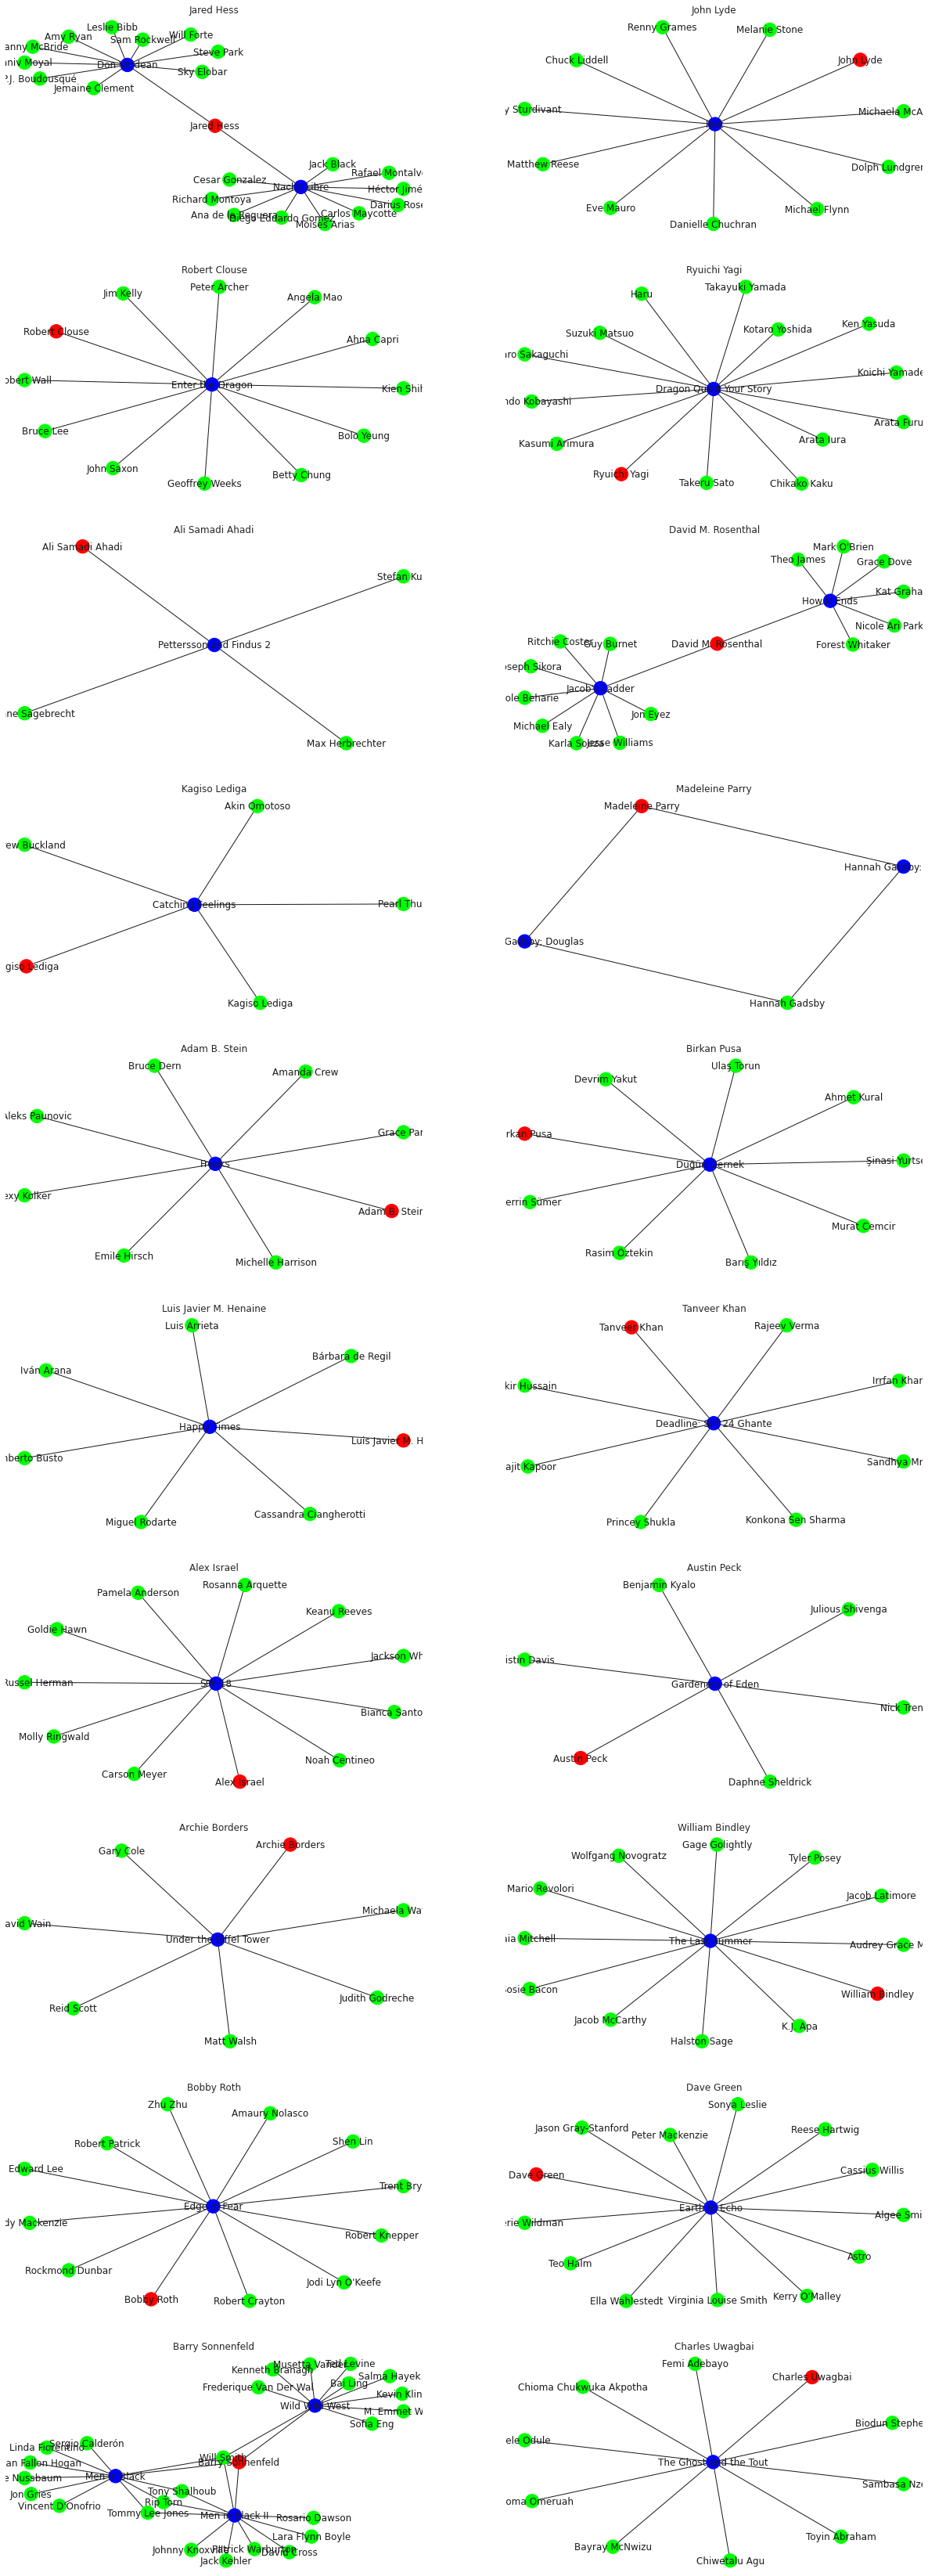

In [319]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(21,21))
fig, axs = plt.subplots(10,2,figsize=(21,6*len(most_similar)))
for i,indices in enumerate(most_similar):
    
    axs[i][0].set_title(df_grouped_by_directors[indices[0]].director.values[0])
    labels1 = nx.get_node_attributes(graphs[indices[0]], 'feature') 
    node_colors1 = nx.get_node_attributes(graphs[indices[0]],'color').values()
    nx.draw(graphs[indices[0]],ax=axs[i][0],with_labels=True,labels=labels1,node_color=node_colors1)
    axs[i][1].set_title(df_grouped_by_directors[indices[1]].director.values[0])
    labels2 = nx.get_node_attributes(graphs[indices[1]], 'feature') 
    node_colors2 = nx.get_node_attributes(graphs[indices[1]],'color').values()
    nx.draw(graphs[indices[1]],ax=axs[i][1],with_labels=True,labels=labels2,node_color=node_colors2)
    

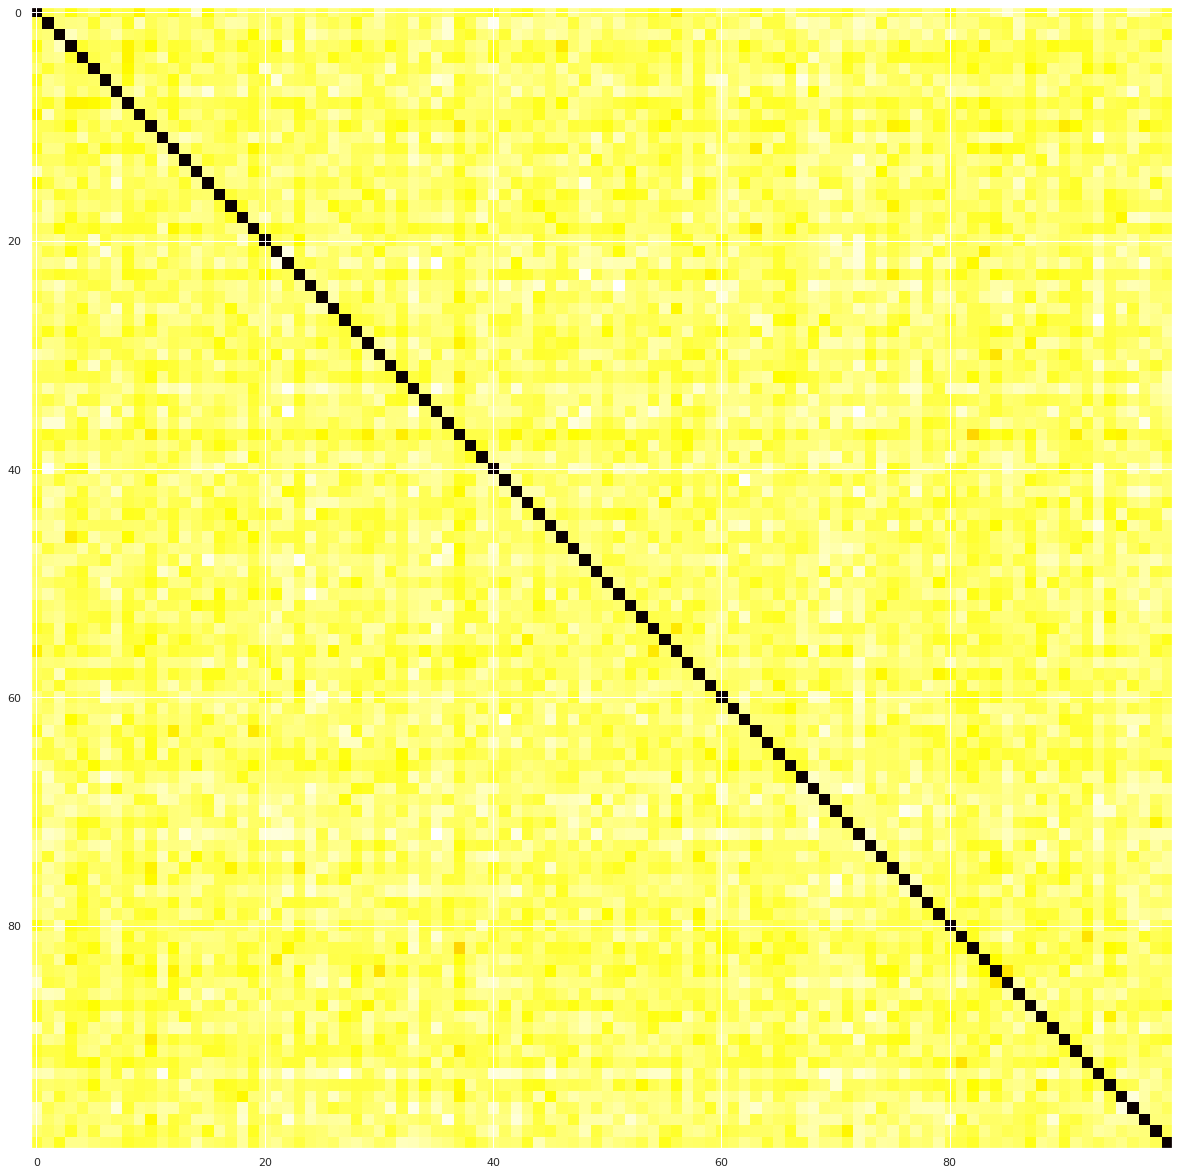

In [273]:
plt.figure(figsize=(21,21))
plt.imshow(distances[:100,:100], cmap='hot')